# 0. Setup

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight') # Use the FiveThirtyEight style sheet
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
dir(Measurement)

['__abstract__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__weakref__',
 '_sa_class_manager',
 '_sa_decl_prepare',
 '_sa_raise_deferred_config',
 '_sa_registry',
 'classes',
 'date',
 'id',
 'metadata',
 'prcp',
 'prepare',
 'registry',
 'station',
 'tobs']

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# 1. Precipitation Analysis
To perform an analysis of precipitation in the area, do the following:

**Find the most recent date in the dataset.**

In [10]:
most_recent_dt = session.query(func.max(Measurement.date)).order_by(Measurement.date.desc()).first()
most_recent_dt[0]

'2017-08-23'

**Using this date, retrieve the previous 12 months of precipitation data by querying the 12 previous months of data.** *Note: Do not pass in the date as a variable to your query.*

- Select only the date and prcp values.
- Load the query results into a Pandas DataFrame, and set the index to the date column.
- Sort the DataFrame values by date.

In [11]:
df = pd.read_sql(
    sql="SELECT date, prcp AS precipitation FROM measurement WHERE date >= '2016-08-23' ORDER BY date",
    con=engine.connect(),
    index_col='date'
)
df = df.dropna() # Drop rows with NaN.
df

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


**Plot the results by using the DataFrame plot method.**

<AxesSubplot:xlabel='Date', ylabel='Inches'>

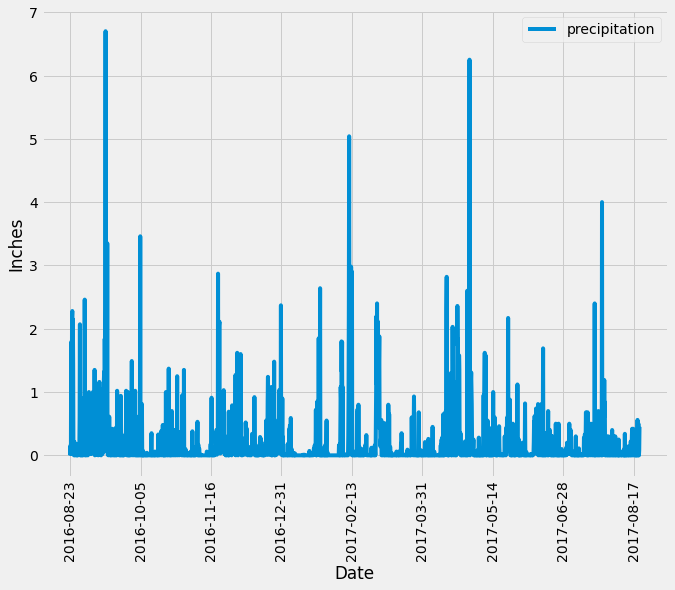

In [12]:
df.plot(
    y='precipitation',
    figsize=(10,8),
    xlabel='Date',
    ylabel='Inches',
    rot=90
)

**Use Pandas to print the summary statistics for the precipitation data.**

In [13]:
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# 2. Station Analysis
To perform an analysis of stations in the area, do the following:

**Design a query to calculate the total number of stations in the dataset.**

In [14]:
session.query(Station).distinct().count()

9

**Design a query to find the most active stations (the stations with the most rows).**

- *Which Station ID has the highest number of observations?*
Station USC00519281 had the highest number of observations (i.e., 2772).

In [15]:
# List the stations and observation counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station). \
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

**Using the most active Station ID, calculate the lowest, highest, and average temperatures.** *Hint: You will need to use functions such as func.min, func.max, func.avg, and func.count in your queries.*

In [16]:
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').first()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').first()

print(f"Lowest Temperature:{min_temp[0]}")
print(f"Highest Temperature:{max_temp[0]}")
print(f"Lowest Temperature:{avg_temp[0]}")

Lowest Temperature:54.0
Highest Temperature:85.0
Lowest Temperature:71.66378066378067


**Design a query to retrieve the previous 12 months of temperature observation data (TOBS).**

In [17]:
last_dt = session.query(func.max(Measurement.date)).filter(Measurement.station=='USC00519281'). \
    order_by(Measurement.date.desc()).first()
last_dt[0]

'2017-08-18'

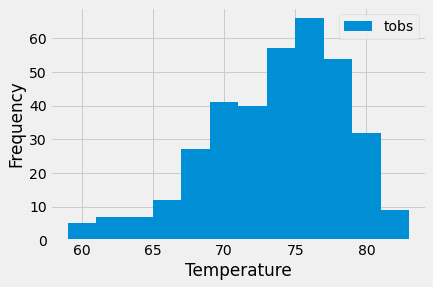

In [18]:
# Filter by the station with the highest number of observations.
temps_lst = []
temps_12mo = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281', \
    Measurement.date>=dt.date(2017, 8, 18)-dt.timedelta(days=365)).all() 
for temp in temps_12mo:
    temps_lst.append(temp.tobs)
    
# Plot the results as a histogram with bins=12.   
plt.hist(temps_lst, bins=12,)
plt.legend(['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [19]:
# Close Session
session.close()